# Homework 3

In [1]:
import numpy as np
from Homework2 import *
from scipy.stats import multivariate_normal

In [2]:
# define parameters
A = (1./6)* np.ones([4,4])+ (1./3)*np.diag([1,1,1,1])

def f(x,m,cov):
    var = multivariate_normal(m,cov)
    return var.pdf(x)

def logf(x,m,cov):
    var = multivariate_normal(m,cov)
    return var.logpdf(x)

p0 = (1./4)*np.ones([4,1])

In [3]:
#define alpha recursion
def alpha(data, A, logf, cov, mean, p0):
    
    #initialization phase
    n = np.shape(A)[0]
    t = np.shape(data)[0]
    #al = (1./n)*np.ones([n,1])
    al =  np.reshape(p0,[n,1])
    #write coefficient in log scale
    al = np.log(al) 
    factors = [logf(data[0],mean[i],cov[i]) for i in range(n)]
    al += np.reshape(factors,[n,1])
    Alog = np.log(A)
    #dynamic extansion of alpha
    
    for k in range(1,t):
        old = np.reshape(al[:,-1],[1,n])
        factors = [logf(data[k],mean[i],cov[i]) for i in range(n)]
        factors = np.reshape(factors,[n,1])
        
        tmp = Alog + old +factors 
        m = np.reshape(np.max(tmp,1),[n,1])
        tmp = tmp - m
        new = m + np.log(np.reshape(np.sum(np.exp(tmp),1),[n,1]))
        al = np.c_[al, new]
    
    return al
        
    

In [4]:
#define beta recursion
def beta(data, A, logf, cov, mean):
    
    #initialization phase
    n = np.shape(A)[0]
    t = np.shape(data)[0]
    bet = np.ones([n,1])
    #write coefficient in log scale
    bet = np.log(bet) 
    Alog = np.log(A)
    #dynamic extansion of beta
    
    for k in range(1,t):
        old = np.reshape(bet[:,-1],[1,n])
        factors = [logf(data[-k],mean[i],cov[i]) for i in range(n)]
        factors = np.reshape(factors,[1,n])
        
        tmp = Alog.T + old + factors
        m = np.reshape(np.max(tmp,1),[n,1])
        tmp = tmp - m
        new = m + np.log(np.reshape(np.sum(np.exp(tmp),1),[n,1]))
        bet = np.c_[bet, new]
    
    return bet

C:\Users\Alexandre Philbert\Anaconda2\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


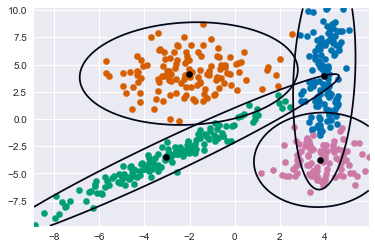

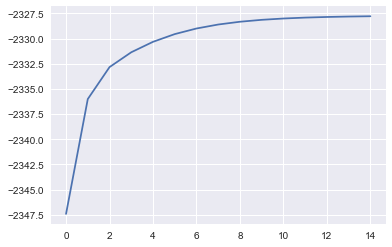

In [5]:
data, test = extractdata('classification_data_HWK2\EmGaussian.data'), extractdata('classification_data_HWK2\EmGaussian.test')
niter = [k for k in range(15)]
var_class, mean_class, pi_class, coef, log_likelyhood = GMM(data,15,4,'general')
plot2DGMM(mean_class, var_class, data, coef,'general')
plt.show()

plt.plot(niter,log_likelyhood)
plt.show()

In [6]:
#compute marginal for given parameters
def marginal_sing(data, A, f, var_class, mean_class, p0):
    al = alpha(data, A, f, var_class, mean_class, p0)
    bet = beta(data, A, f, var_class, mean_class )
    n = np.shape(bet)[1]
    bet = bet[:,n:None:-1]
    #computation in log scale
    res = al+bet
    m = np.max(res,0)
    norm = res - m
    #stable formulation
    norm = m + np.log(np.sum(np.exp(norm),0))
    single = res-norm
    
    return np.exp(single), norm



In [7]:
def marginal_double(data,A,f,var_class,mean_class, norm, p0, classnum = 4):
    al = alpha(data, A, f, var_class, mean_class, p0)
    bet = beta(data, A, f, var_class, mean_class )
    n = np.shape(bet)[1]
    bet = bet[:,n:None:-1]
    al = al[:,0:-1]
    bet = bet[:,1:]
    mat = np.zeros([classnum,classnum,n-1])
    #norm = np.zeros(([classnum,classnum]))
    for j in range (classnum):
        for i in range(classnum):
            alc = np.reshape(al[j,:],[1,n-1])
            betc = np.reshape(bet[i,:],[1,n-1])
            factors = [logf(data[k],mean_class[i],var_class[i]) for k in range(1,n)]
            factors = np.reshape(factors, [1,n-1] )
            tmp = alc+betc+ np.log(A[i,j]) + factors
            mat[i,j] = tmp
    #normalize
    #m = np.max(np.max(mat,0),0) 
    #norm = mat - m
    #norm = m + np.log(np.sum(np.sum(np.exp(norm),0),0))
    double = mat-norm
    
    return np.exp(double)

In [8]:
def marginal(data,A, f,var_class,mean_class, p0, classnum = 4):
    
    #compute single marginal
    al = alpha(data, A, f, var_class, mean_class, p0)
    bet = beta(data, A, f, var_class, mean_class )
    n = np.shape(bet)[1]
    bets = bet[:,n:None:-1]
    #computation in log scale
    res = al+bets
    m = np.max(res,0)
    norm = res - m
    #stable formulation
    norm = m + np.log(np.sum(np.exp(norm),0))
    single = res-norm
    
    #compute double marginal
    n = np.shape(bet)[1]
    bet = bet[:,n:None:-1]
    al = al[:,0:-1]
    bet = bet[:,1:]
    mat = np.zeros([classnum,classnum,n-1])
    #norm = np.zeros(([classnum,classnum]))
    for j in range (classnum):
        for i in range(classnum):
            alc = np.reshape(al[j,:],[1,n-1])
            betc = np.reshape(bet[i,:],[1,n-1])
            factors = [f(data[k],mean_class[i],var_class[i]) for k in range(1,n)]
            factors = np.reshape(factors, [1,n-1] )
            tmp = alc+betc+ np.log(A[i,j]) + factors
            mat[i,j] = tmp
    
    double = mat-norm[0]
    
    return np.exp(single), np.exp(double), norm


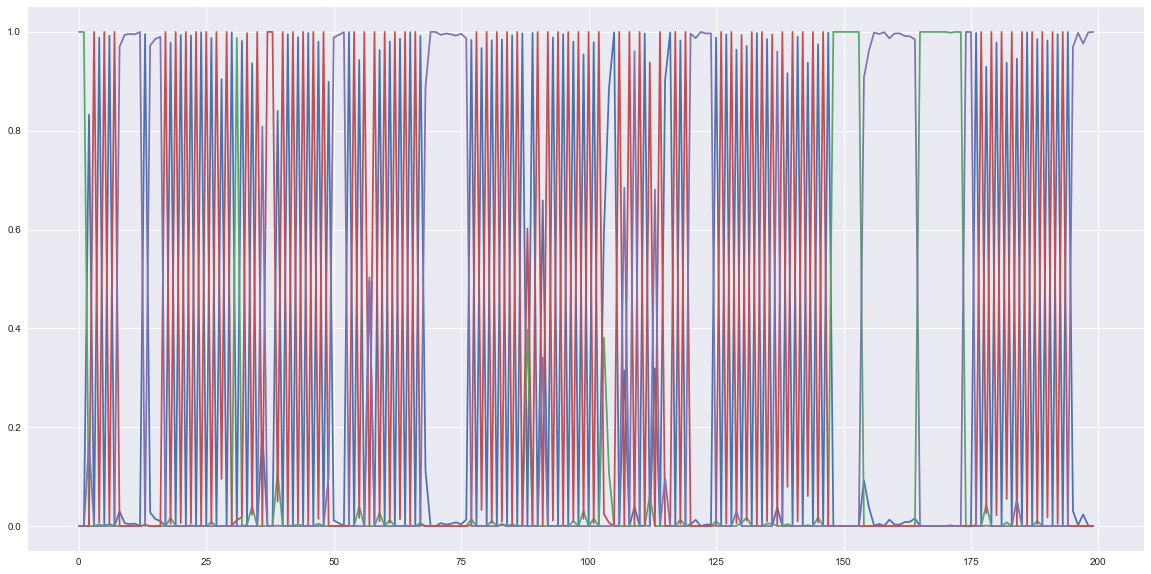

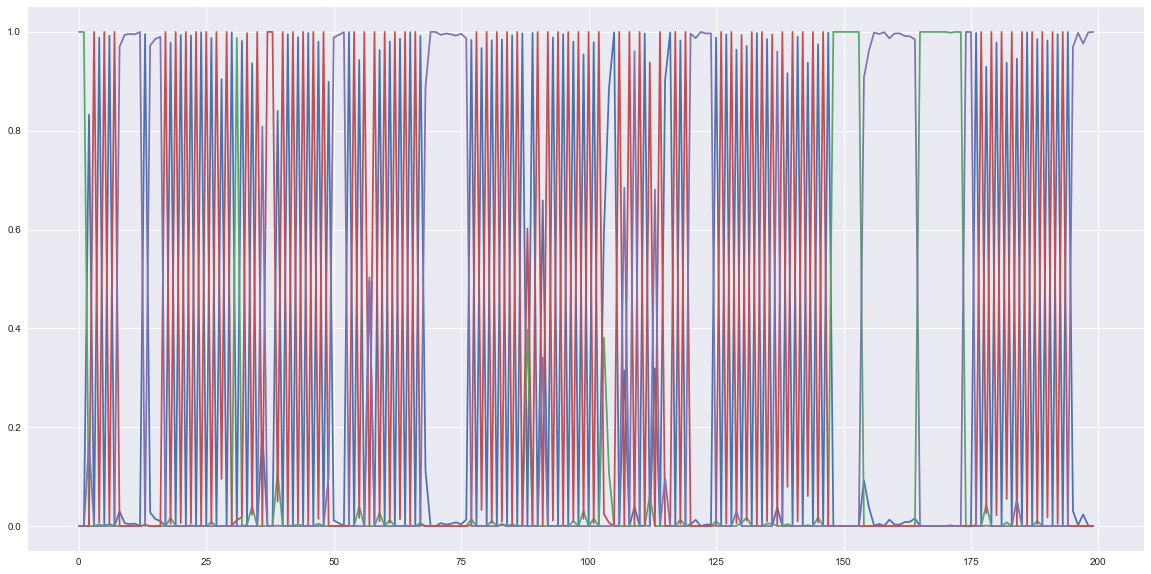

In [9]:
#res, norm = marginal_sing(test, A, logf, var_class, mean_class,p0)

single, double, norm = marginal(test, A, logf, var_class, mean_class,p0)

x = [k for k in range(200)]
plt.figure(figsize=(20,10))
for k in range(4):
    plt.plot(x,single[k,0:200])
plt.show()

trys = np.sum(double,0)
plt.figure(figsize=(20,10))
for k in range(4):
    plt.plot(x,trys[k,0:200])
plt.show()



In [10]:
def HMM(data, niter,m,v, numclass = 4, f = logf):
    #initialize parameters
    p0 = (1.0/4)*np.ones(numclass)
    A = (1.0/4)*np.ones([numclass,numclass])
    var_class = v#[np.diag([1,1]) for k in range(numclass)]
    datamin = np.min(data,0)
    datamax = np.max(data,0)
    mean_class = m#[datamin+(datamax-datamin)*np.random.rand(2) for k in range(numclass)]
    n,d = np.shape(data)
    loglik = np.zeros(niter)
    
    
    for k in range(niter):
        
        # E step
        
        prob, mat, norm = marginal(data, A, f, var_class, mean_class, p0)
        loglik[k]=norm[0]
        #mat = marginal_double(data, A, f, var_class, mean_class, norm[0],p0)
        # M setp
        
        #p0 update
        p0 = prob[:,0]
        #A update
        tmp = np.sum(mat,2)
        reg = np.sum(mat,0)
        div = np.reshape(np.sum(prob,1),[numclass,1])
        A = tmp/div
        
        #mean update
        for k in range(numclass):
            coef  = np.reshape(prob[k,:],[n,1])*data
            mean_class[k] = np.sum(coef,0)/sum(prob[k,:])
        for k in range(numclass):
            coef = (data-mean_class[k])*np.reshape(prob[k,:],[n,1])
            #print(np.shape(coef))
            var_class[k] = np.dot(data.T,coef)/sum(prob[k,:])
        #print(var_class)
    
    return A,var_class, mean_class,p0, prob, loglik
        
    

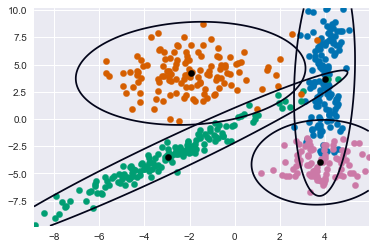

In [17]:
A,var_cl, mean_cl,p0, prob, loglik = HMM(data, 15, mean_class, var_class)

plot2DGMM(np.array(mean_cl), np.array(var_cl), data, prob.T, cov='general')

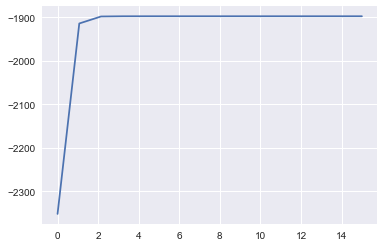

In [18]:
plt.plot(np.linspace(0,15,15),loglik)
plt.show()


In [19]:
#define alpha recursion
def map_propagation(data, A, f, cov, mean, p0):
    
    #initialization phase
    n = np.shape(A)[0]
    t = np.shape(data)[0]
    #al = (1./n)*np.ones([n,1])
    al =  np.reshape(p0,[n,1])
    #write coefficient in log scale
    al = np.log(al) 
    factors = [logf(data[0],mean[i],cov[i]) for i in range(n)]
    al += np.reshape(factors,[n,1])
    Alog = np.log(A)
    previous = np.reshape(np.zeros(4),[4,1])
    
    #dynamic extansion of alpha
    
    for k in range(1,t):
        old = np.reshape(al[:,-1],[1,n])
        factors = [logf(data[k],mean[i],cov[i]) for i in range(n)]
        factors = np.reshape(factors,[n,1])
        
        tmp = Alog + old +factors 
        new = np.reshape(np.max(tmp,1),[n,1])
        prev = np.where(tmp == new)[1]
        prev = np.reshape(prev,[n,1])
        al = np.c_[al, new]
        previous = np.c_[previous, prev]
    
    previous = previous[:,1:]
    # construct the sequence with the highest probability
    lab = np.zeros(t)
    lab[t-1] = np.where(al[:,-1]==max(al[:,-1]))[0][0]
    for k in range(2,t+1):
        lab[-k]= previous[int(lab[1-k]),1-k]
        
    return lab 
        
    

In [20]:
lab = map_propagation(data, A, f, var_cl, mean_cl, p0)

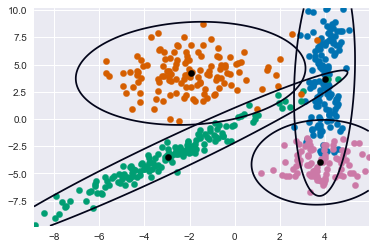

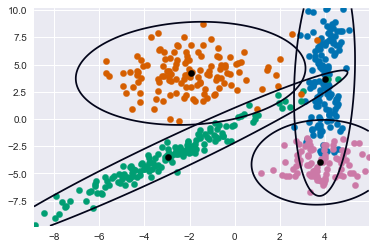

In [21]:
plot2DGMM(np.array(mean_cl), np.array(var_cl), data, lab, 'general', False)
plot2DGMM(np.array(mean_cl), np.array(var_cl), data, prob.T, 'general')

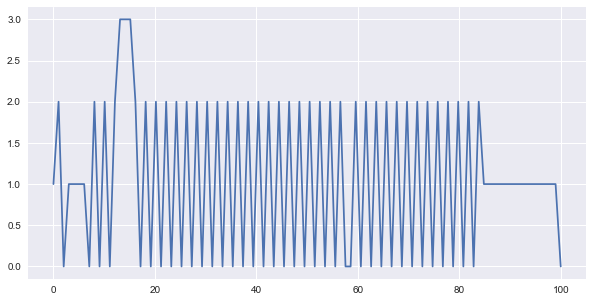

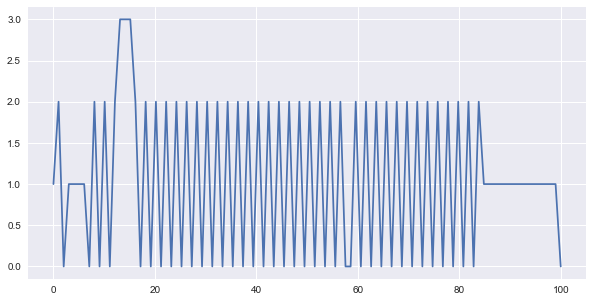

In [22]:
indiv = np.argmax(prob.T, axis = 1 )
seq = lab


plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,100,100), indiv[:100])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,100,100), seq[:100])
plt.show()